In [214]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import copy
import math
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve, auc
from datetime import datetime, timedelta

In [215]:
df = pd.DataFrame([]) # 데이터프레임 만들기
df = pd.read_csv('../data/Data_Final_SeqDone.csv') 

df['Code'] = df['Code'].astype('category')

df['Date_Time'] = pd.to_datetime(df['Date_Time'].str.strip(), format="%Y-%m-%d %H:%M:%S", errors="raise")

df.head()

,Code,Blood_Glucose,Patient_ID,Code_Description,Date_Time
0,58,101.0,31,PRE_BREAKFAST,1991-05-20 08:00:00
1,33,5.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00
2,34,27.0,31,NPH_INSULIN_DOSE,1991-05-20 08:00:00
3,60,89.0,31,PRE_LUNCH,1991-05-20 12:00:00
4,33,3.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00


In [216]:
plt.rc("font", family="Malgun Gothic") # 한글 출력 적용

group_df = df.groupby('Patient_ID')

df_agg = pd.DataFrame({
    'median' : group_df['Blood_Glucose'].mean(),
    'std' : group_df['Blood_Glucose'].std(),
    'highs_perday' : group_df.apply(lambda group : group[group['Blood_Glucose']>200]['Blood_Glucose'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'hypos_perday' : group_df.apply(
        lambda group : group[group['Code_Description']=='HYPOGLYCEMIC_SYMPTOMS']['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'exercise_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='TYPICAL_EXERCISE') |
                            (group['Code_Description']=='LESS_EXERCISE') |
                            (group['Code_Description']=='MORE_EXERCISE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'irregular_diet_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='MORE_MEAL_INJESTION') |
                            (group['Code_Description']=='LESS_MEAL_INJESTION')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'irregular_exercise_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='LESS_EXERCISE') |
                            (group['Code_Description']=='MORE_EXERCISE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'readings_perday' : group_df['Date_Time'].apply(lambda group : group.count()
                                                /((group.max() - group.min()).days)),
    'snacks_perday' : group_df.apply(lambda group : group[group['Code_Description']=='PRE_SNACK']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'regular_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='REGULAR_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'nph_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='NPH_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'ultralente_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='ULTRALENTE_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'insulin_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='REGULAR_INSULIN_DOSE') |
                            (group['Code_Description']=='NPH_INSULIN_DOSE') |
                            (group['Code_Description']=='ULTRALENTE_INSULIN_DOSE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'postmeal_median_bg': group_df.apply(
        lambda group : group[(group['Code_Description']=='POST_LUNCH')]['Blood_Glucose'].median())
})

df_agg.loc[df_agg['postmeal_median_bg'].isnull(), 'postmeal_median_bg'] = df_agg.loc[df_agg['postmeal_median_bg'].isnull(), 'median']
df_agg['hypo_flag']= df_agg['hypos_perday']>0;

df_agg.head(15)

,median,std,highs_perday,hypos_perday,exercise_perday,irregular_diet_perday,irregular_exercise_perday,readings_perday,snacks_perday,regular_insulin_perday,nph_insulin_perday,ultralente_insulin_perday,insulin_perday,postmeal_median_bg,hypo_flag
Patient_ID,,,,,,,,,,,,,,,
1,67.783333,85.840507,0.762963,0.362963,0.000000,0.000000,0.000000,6.666667,0.000000,2.703704,0.970370,0.000000,3.674074,67.783333,True
2,100.045205,105.922854,1.715789,0.000000,0.000000,0.000000,0.000000,7.684211,0.000000,3.905263,0.021053,0.000000,3.926316,100.045205,False
3,70.313793,80.270788,0.657895,0.078947,0.000000,0.263158,0.000000,7.631579,0.394737,1.552632,0.026316,1.842105,3.421053,178.000000,True
4,82.479310,96.339767,1.131579,0.026316,0.000000,0.157895,0.000000,7.631579,0.842105,1.789474,1.421053,0.473684,3.684211,187.500000,True
5,85.882759,98.199818,1.100000,0.000000,0.000000,0.050000,0.000000,7.250000,0.900000,1.725000,1.875000,0.000000,3.600000,166.000000,False
6,91.493243,101.992763,1.291667,0.000000,0.000000,0.000000,0.000000,6.166667,0.000000,2.458333,1.041667,0.000000,3.500000,91.493243,False
7,86.112069,92.814135,1.121212,0.000000,0.000000,0.000000,0.000000,7.030303,0.000000,2.727273,1.000000,0.000000,3.727273,86.112069,False
8,144.542857,107.902932,1.771429,0.428571,0.057143,0.228571,0.000000,5.000000,0.457143,0.200000,0.114286,0.000000,0.314286,227.000000,True
9,83.586207,102.218540,1.307692,0.000000,0.115385,0.038462,0.076923,7.807692,0.884615,3.000000,0.846154,0.000000,3.846154,184.500000,False


In [217]:
X = np.array(df_agg.values[:,[4,5,8,10, 11,13]], dtype='f')
y = np.array(df_agg.values[:, 14], dtype='f')

X_train, X_test,y_train,  y_test = train_test_split(X,y, test_size=0.4, random_state=1004)
# train set 60%, test set 40%비율로 무작위 추출하여 데이터셋 분할

params = {
    'n_estimators' : [50, 100, 150, 200],      # 생성할 트리의 개수
    'learning_rate' : [0.05, 0.1]    # 학습 진행마다 적용하는 학습률
}

gbm = GradientBoostingClassifier(random_state=0) # gbm 알고리즘
gb_grid_cv =GridSearchCV(gbm, param_grid=params, cv=2) # gbm 하이퍼파라미터 세팅
gb_grid_cv.fit(X_train, y_train)

y_pred = gb_grid_cv.best_estimator_.predict(X_test)
gb_grid_cv_accuracy = accuracy_score(y_test,y_pred)

print('GBM prediction accuracy:{0:4f}'.format(gb_grid_cv_accuracy))

GBM prediction accuracy:0.750000


In [218]:
conf_array = confusion_matrix(y_test, y_pred) # 오차행렬

pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
Actual,,,
0.0,11,4,15
1.0,3,10,13
All,14,14,28


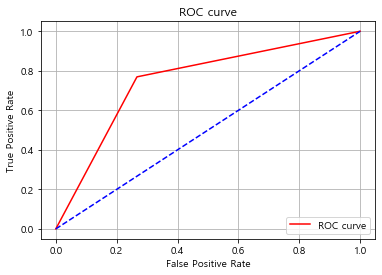

In [219]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='red',label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.grid()
plt.legend(loc="lower right")
plt.show()